<a href="https://colab.research.google.com/github/SIVANESAN2061/dig_aud_reg_CNN/blob/main/exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-3-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-3-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


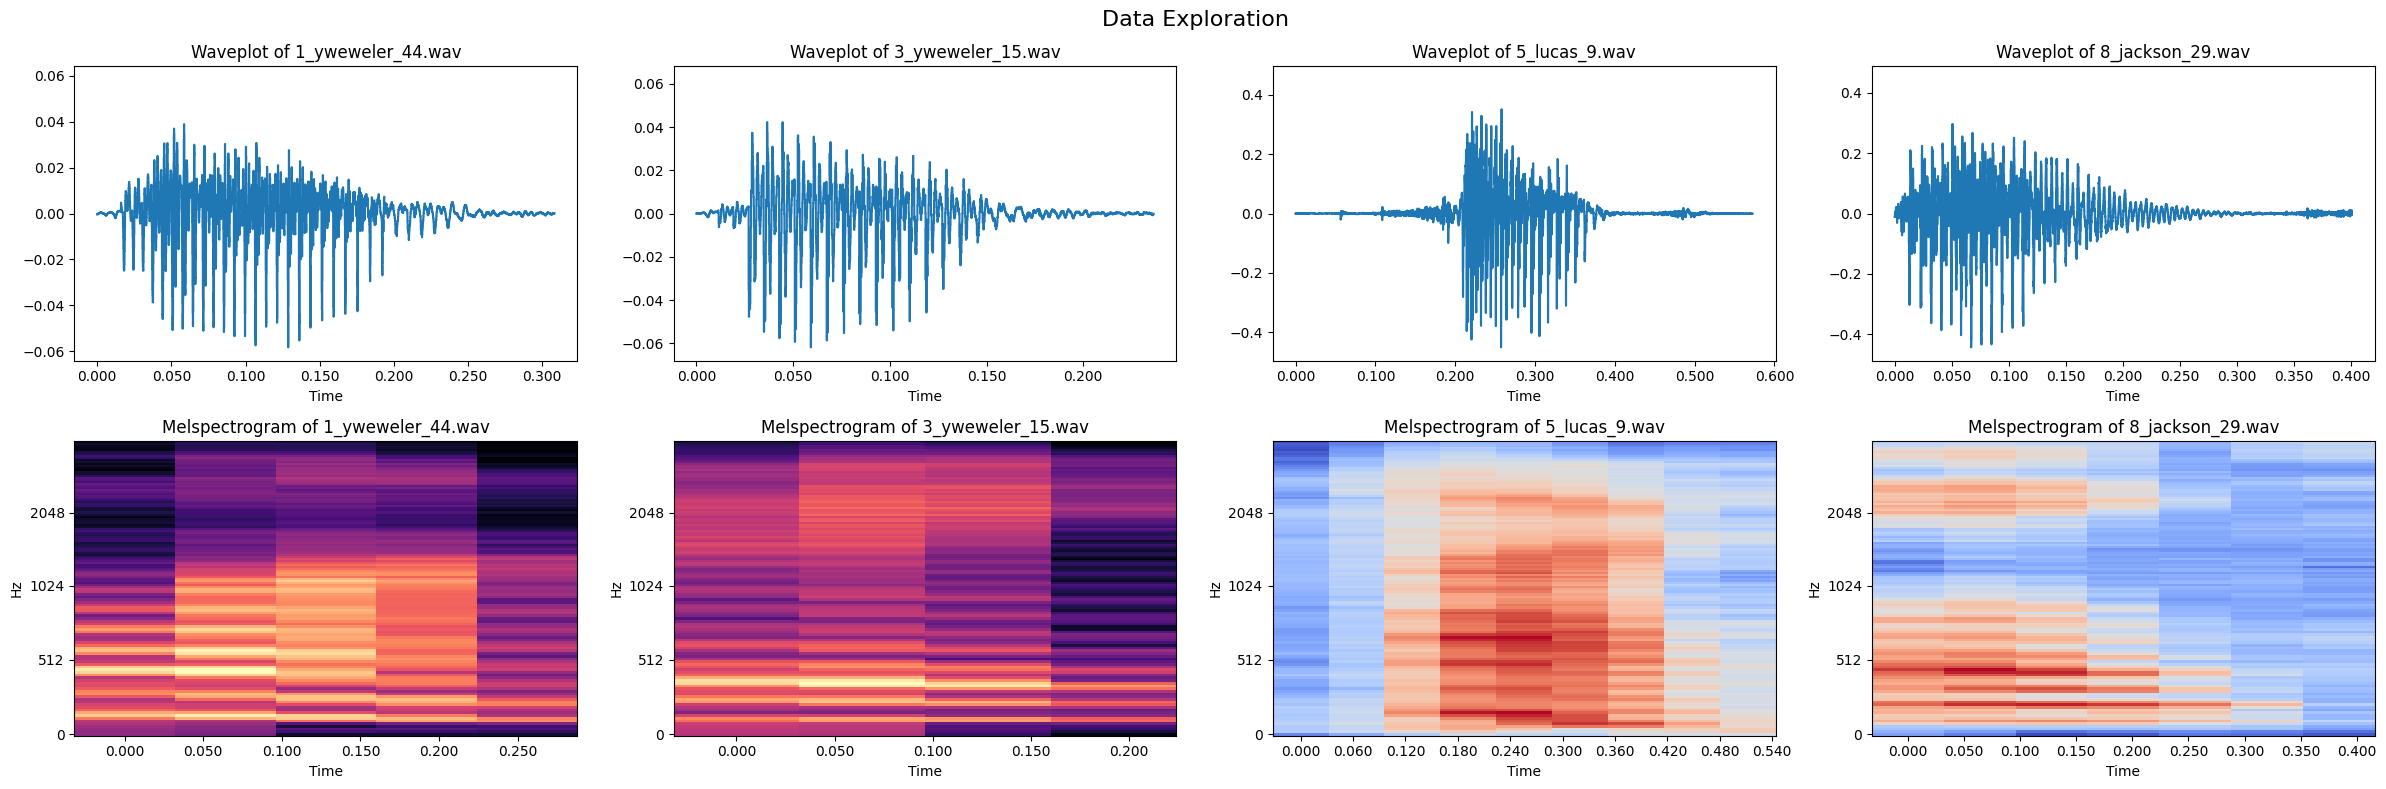

In [ ]:
visualize_digits = [1, 3, 5, 8]

description = pd.read_csv('/content/drive/MyDrive/PROJECT/rec/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/PROJECT/rec/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3020/3020 [01:10<00:00, 42.87it/s]


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Assuming you have features and labels defined earlier

# Define the RNN model
model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(features.shape[1], features.shape[2])),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 35914 (140.29 KB)
Trainable params: 35914 (140.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/10
24/24 [==============================] - 10s 192ms/step - loss: 2.2873 - accuracy: 0.1346 - val_loss: 2.2412 - val_accuracy: 0.2031
Epoch 2/10
24/24 [==============================] - 4s 157ms/step - loss: 2.1908 - accuracy: 0.2387 - val_loss: 2.1090 - val_accuracy: 0.2740
Epoch 3/10
24/24 [==============================] - 5s 229ms/step - loss: 2.0127 - accuracy: 0.3009 - val_loss: 1.9134 - val_accuracy: 0.3244
Epoch 4/10
24/24 [==============================] - 4s 157ms/step - loss: 1.8424 - accuracy: 0.3631 - val_loss: 1.8326 - val_accuracy: 0.3228
Epoch 5/10
24/24 [==============================] - 4s 157ms/step - loss: 1.7859 - accuracy: 0.3563 - val_loss: 1.7379 - val_accuracy: 0.3937
Epoch 6/10
24/24 [==============================] - 6s 239ms/step - loss: 1.6596 - accuracy: 0.4009 - val_loss: 1.6527 - val_accuracy: 0.4126
Epoch 7/10
24/24 [==============================] - 4s 147ms/step - loss: 1.5564 - accuracy: 0.4375 - val_loss: 1.6737 - val_accuracy: 0.4000
Epoch

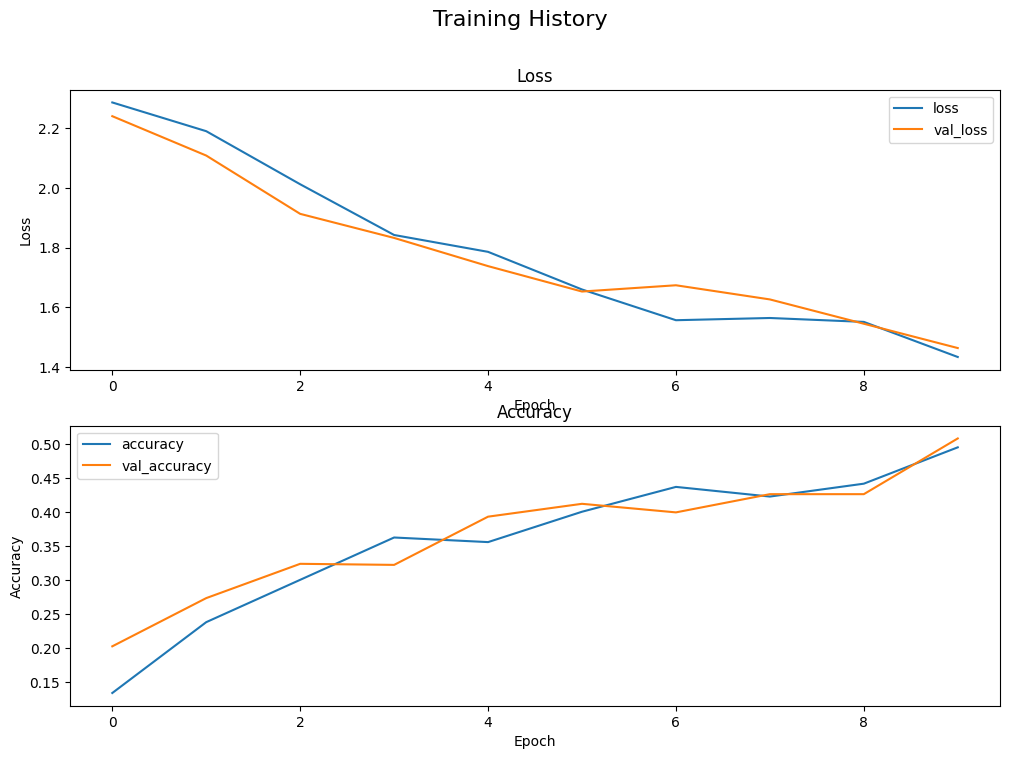

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
